# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [2]:
def annotate_heatmap(data):
    """Loops over data dimensions and create text annotations.
    
    Args:
        data: Data used to annotate.     
    Reference:
        https://matplotlib.org/3.1.0/gallery/images_contours_and_fields/image_annotated_heatmap.html
    """
    LENGTH = len(data)
    
    for i in range(LENGTH):
        for j in range(LENGTH):
            ax.text(j, i, corr.iloc[i, j].round(2), ha='center', va='center', color='black', fontsize='x-large')

## Rotten Tomatoes

In [3]:
tomatoes = pd.read_json('data/rotten-tomatoes.json.gz', lines=True, encoding='utf-8')

In [4]:
# Drop rows with no audience average rating (out of 5)
tomatoes_cleaned = tomatoes[tomatoes['audience_average'].notnull()]

# Drop rows with no critic average rating (out of 10)
tomatoes_cleaned = tomatoes_cleaned[tomatoes_cleaned['critic_average'].notnull()]

# Only keep columns we need
tomatoes_cleaned = tomatoes_cleaned[['imdb_id', 'audience_average', 'audience_percent', 'audience_ratings', 'critic_average', 'critic_percent']]

tomatoes_cleaned.reset_index(drop=True)

,imdb_id,audience_average,audience_percent,audience_ratings,critic_average,critic_percent
0,tt0325980,3.9,86.0,33125227.0,7.1,79.0
1,tt4882376,4.1,80.0,2139.0,7.8,88.0
2,tt0099763,3.6,71.0,11482.0,7.6,86.0
3,tt1371111,3.6,66.0,187204.0,6.6,66.0
4,tt1189073,3.9,84.0,26836.0,7.4,80.0
5,tt1787725,3.7,74.0,1498.0,7.0,88.0
6,tt0117665,3.6,85.0,92824.0,6.6,73.0
7,tt1611224,3.2,50.0,242347.0,4.9,35.0
8,tt3966544,4.0,87.0,427.0,7.4,100.0
9,tt0780521,3.7,74.0,260776.0,7.4,85.0


## Wikidata

In [5]:
wikidata = pd.read_json('data/wikidata-movies.json.gz', lines=True, encoding='utf-8')

# Drop rows with no valid box office gross values
wikidata_cleaned = wikidata[wikidata['nbox'].notnull()]

# Drop rows with no valid budget values
wikidata_cleaned = wikidata_cleaned[wikidata_cleaned['ncost'].notnull()]

# Unit conversion of a dollar to a million dollar, and then keeping only one decimal place
MILLION = 1000000
wikidata_cleaned['nbox'] = (wikidata_cleaned['nbox'] / MILLION).round(1)
wikidata_cleaned['ncost'] = (wikidata_cleaned['ncost'] / MILLION).round(1)

# Gross Profit = Box Office Takings - Film Budget
wikidata_cleaned['gross_profit'] = wikidata_cleaned['nbox'] - wikidata_cleaned['ncost']

# https://en.wikipedia.org/wiki/Profit_margin
wikidata_cleaned['profit_margin'] = (wikidata_cleaned['gross_profit'] / wikidata_cleaned['nbox'] * 100).round()

# Set negative profit margin values < -100 to -100 (we know negative profit margin values are bad;
# though it isn't in our interest to care how bad they are when << 0 for this analysis)
wikidata_cleaned['profit_margin'] = wikidata_cleaned['profit_margin'].clip(-100)

# Only keep columns we need
wikidata_cleaned = wikidata_cleaned[['cast_member', 'label', 'imdb_id', 'nbox', 'ncost', 'made_profit', 'gross_profit', 'profit_margin']]

wikidata_cleaned.reset_index(drop=True)

,cast_member,label,imdb_id,nbox,ncost,made_profit,gross_profit,profit_margin
0,"[Q38111, Q211553, Q177311, Q8927, Q173399, Q20...",Inception,tt1375666,825.5,160.0,1.0,665.5,81.0
1,"[Q80938, Q231951, Q172678, Q351479, Q224081, Q...",Basic,tt0264395,42.0,50.0,0.0,-8.0,-19.0
2,"[Q20178, Q36949, Q211280, Q229319, Q447892, Q1...",Goodfellas,tt0099685,46.8,25.0,1.0,21.8,47.0
3,"[Q2680, Q604849, Q63187, Q2642325, Q532180, Q3...",A Good Day to Die Hard,tt1606378,304.7,92.0,1.0,212.7,70.0
4,"[Q81328, Q103894, Q108941, Q210447, Q309589, Q...",Star Wars Episode IV: A New Hope,tt0076759,775.4,11.0,1.0,764.4,99.0
5,NaN,Robin Hood,tt0070608,32.1,1.5,1.0,30.6,95.0
6,"[Q316446, Q25144, Q456651, Q7352309, Q229651, ...",Moon,tt1182345,9.8,5.0,1.0,4.8,49.0
7,"[Q129591, Q129817, Q36301, Q189226, Q29055, Q1...",Les Misérables,tt1707386,441.8,61.0,1.0,380.8,86.0
8,"[Q25089, Q23301, Q39666, Q170572, Q307882, Q21...",To Rome with Love,tt1859650,73.2,17.0,1.0,56.2,77.0
9,"[Q193048, Q206890, Q296883, Q42204, Q43416, Q4...",The Matrix,tt0133093,463.5,63.0,1.0,400.5,86.0


## Wikidata + Rotten Tomatoes

In [6]:
# Join the Wikidata Movies data with the Rotten Tomatoes
data = pd.merge(wikidata_cleaned, tomatoes_cleaned, on='imdb_id', how='inner')
data = data.dropna()
data

,cast_member,label,imdb_id,nbox,ncost,made_profit,gross_profit,profit_margin,audience_average,audience_percent,audience_ratings,critic_average,critic_percent
0,"[Q38111, Q211553, Q177311, Q8927, Q173399, Q20...",Inception,tt1375666,825.5,160.0,1.0,665.5,81.0,4.2,91.0,568239.0,8.1,86.0
1,"[Q80938, Q231951, Q172678, Q351479, Q224081, Q...",Basic,tt0264395,42.0,50.0,0.0,-8.0,-19.0,3.2,63.0,56707.0,4.5,21.0
2,"[Q20178, Q36949, Q211280, Q229319, Q447892, Q1...",Goodfellas,tt0099685,46.8,25.0,1.0,21.8,47.0,4.3,97.0,428024.0,9.0,96.0
3,"[Q2680, Q604849, Q63187, Q2642325, Q532180, Q3...",A Good Day to Die Hard,tt1606378,304.7,92.0,1.0,212.7,70.0,3.0,40.0,117482.0,3.9,14.0
4,"[Q81328, Q103894, Q108941, Q210447, Q309589, Q...",Star Wars Episode IV: A New Hope,tt0076759,775.4,11.0,1.0,764.4,99.0,4.1,96.0,858665.0,8.6,93.0
6,"[Q316446, Q25144, Q456651, Q7352309, Q229651, ...",Moon,tt1182345,9.8,5.0,1.0,4.8,49.0,4.0,89.0,100186.0,7.5,89.0
7,"[Q129591, Q129817, Q36301, Q189226, Q29055, Q1...",Les Misérables,tt1707386,441.8,61.0,1.0,380.8,86.0,4.0,79.0,264761.0,6.9,69.0
8,"[Q25089, Q23301, Q39666, Q170572, Q307882, Q21...",To Rome with Love,tt1859650,73.2,17.0,1.0,56.2,77.0,3.0,40.0,29681.0,5.5,45.0
9,"[Q193048, Q206890, Q296883, Q42204, Q43416, Q4...",The Matrix,tt0133093,463.5,63.0,1.0,400.5,86.0,3.6,85.0,33323365.0,7.6,87.0
10,"[Q38119, Q19190, Q39476, Q170428, Q296008, Q10...",Harry Potter and the Order of the Phoenix,tt0373889,939.9,150.0,1.0,789.9,84.0,3.9,81.0,2332189.0,6.9,78.0


## Relationship between the Box Office Gross and the Audience Average Rating

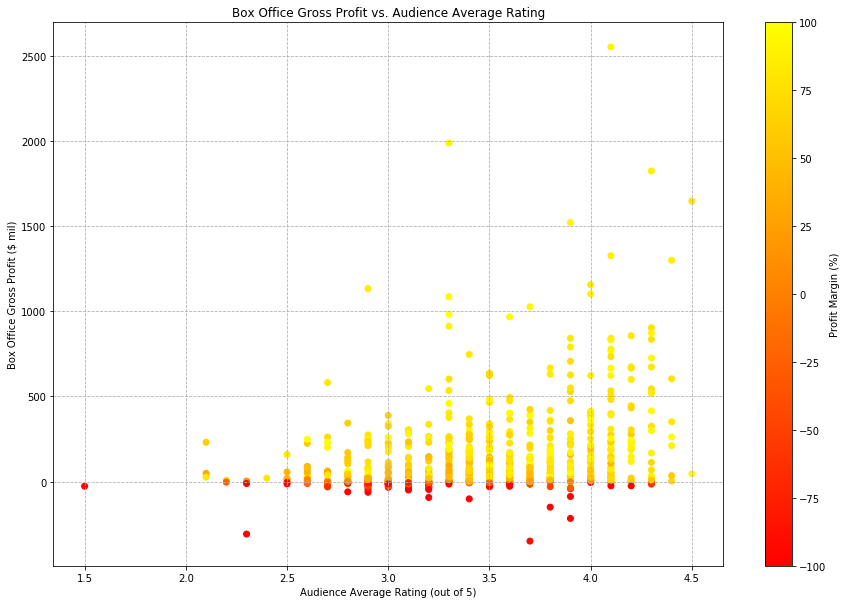

In [7]:
plt.figure(figsize=(15, 10))
plt.title('Box Office Gross Profit vs. Audience Average Rating')
plt.xlabel('Audience Average Rating (out of 5)')
plt.ylabel('Box Office Gross Profit ($ mil)')
plt.scatter('audience_average', 'gross_profit', c='profit_margin', cmap='autumn', alpha=1, data=data)
plt.colorbar().set_label('Profit Margin (%)')
plt.grid(ls='--')
plt.show()

Based on the scatter plot above, we can observe an increase in gross profit as audience average rating values increase. Also, we can observe higher gross profit margin values for higher audience average rating values.

**Note:** Some movies were tremendously unprofitable; so the profit margin values of the movies have been adjusted to -100 because what matters in this analysis is not to visualize how unprofitable they were but they were unprofitable.

## Correlations between Key Variables

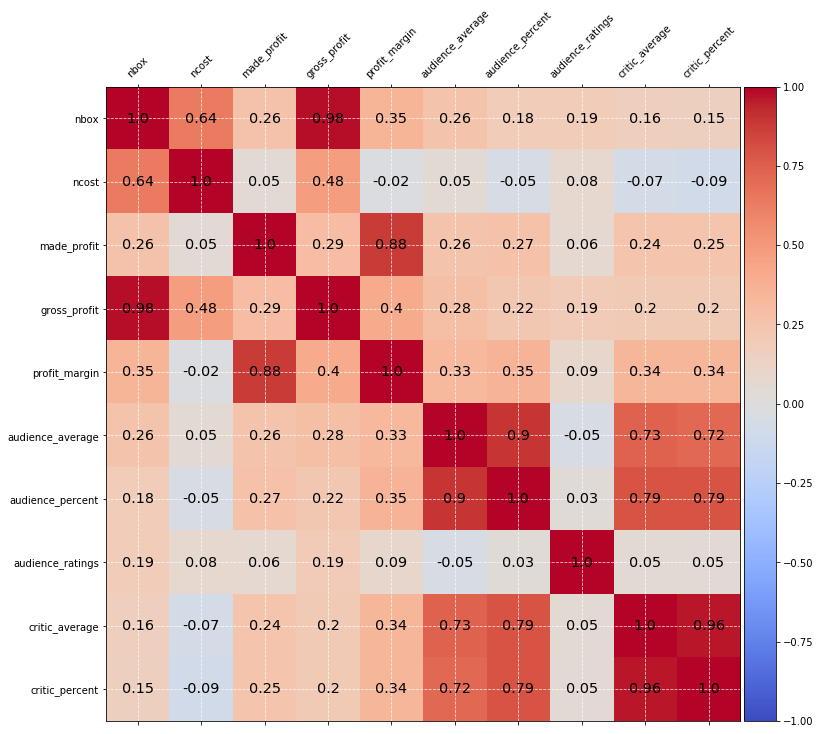

In [8]:
# Remove all non-numerical variables (i.e., categorical variables) for the calculation of correlations
data = data.select_dtypes([np.number])

# https://link.medium.com/2HjSYb4nJY
corr = data.corr()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
im = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
ticks = np.arange(0, len(data.columns), 1)
ax.set_xticks(ticks)
plt.xticks(rotation=45)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.grid(ls='--', c='white', alpha=0.8)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax)
annotate_heatmap(corr)
plt.show()

Based on the correlation matrix above, we can observe a number of interesting correlations:

1. a **very strong positive** correlation ($r\approx0.98$) between **nbox** (box office gross) and **gross_profit** (box office gross profit);

2. a **strong positive** correlation ($r\approx0.64$) between **nbox** and **ncost** (film budget);

3. a **strong positive** correlation ($r\approx0.73$) between **audience_average** (audience average rating) and **critic_average** (critic average rating); and

4. a **moderately strong positive** correlation ($r\approx0.48$) between **ncost** and **gross_profit**.

# Ordinary Least Squares Analysis and Statistical Hypothesis Test

Given the model for least squares regression line: $y=\alpha+\beta x+\epsilon$, where $\epsilon~N(0, \sigma)$

- $\alpha$ is the intercept
- $\beta$ is the slope
- $\epsilon$ is the vertical difference between the population point $(x,y)$ and the regression line

## 1. Hypotheses

Is the movie rating of the audience significantly (linearly) related to the success of the movie? (**Note:** we define success in terms of the gross profit.)

$H_0: \beta=0$

$H_1: \beta\neq0$

## 2. Test Statistic

Assumptions:
1. The sample is representative of the population.
2. The relationship between the variables is linear.
3. The residuals are normally distributed and iid.

### Testing Normality of Audience Average Rating

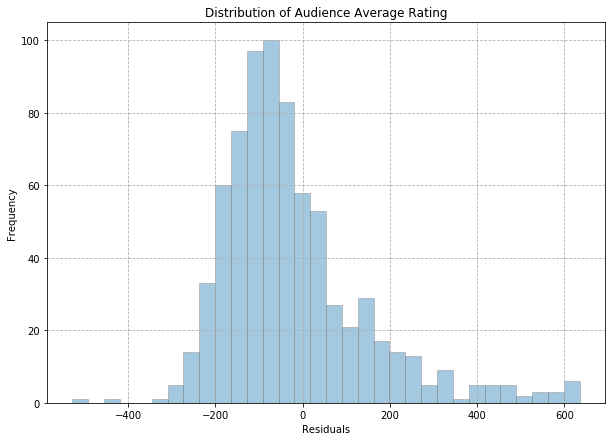

In [9]:
reg = stats.linregress(data['audience_average'], data['gross_profit'])

residuals = data['gross_profit'] - (reg.slope * data['audience_average'] + reg.intercept)

# Remove data (potential outliers) that are more than 3 standard deviations far away from the mean
residuals = residuals[~((residuals - residuals.mean()).abs() > 3 * residuals.std())]

# https://blogs.sas.com/content/iml/2014/07/14/log-transformation-of-pos-neg.html
# L(x) = sign(x) * log(|x| + 1)
# residuals = np.sign(residuals) * np.log(residuals.abs() + 1)

plt.figure(figsize=(10, 7))
sns.distplot(residuals, hist_kws=dict(edgecolor="grey"), kde=False)
plt.title('Distribution of Audience Average Rating')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(ls='--')
plt.show()

In [10]:
print('p-value:', stats.normaltest(residuals).pvalue)

p-value: 1.474675466268583e-43


In [11]:
residuals.describe()

count    746.000000
mean     -23.671504
std      166.105551
min     -527.289710
25%     -129.573277
50%      -62.670518
75%       37.803453
max      634.854112
dtype: float64

Since $p \approx 1.47 \times 10^{-43} \ll \alpha = 0.05$, testing the normality fails; however, we can still proceed with the ordinary least squares by the central limit theorem because we have enough data, $n=746$.

In [12]:
data_ols = pd.DataFrame({'y': data['gross_profit'], 'x': data['audience_average'], 'intercept': 1})
results = sm.OLS(data_ols['y'], data_ols[['x', 'intercept']]).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     65.30
Date:                Fri, 02 Aug 2019   Prob (F-statistic):           2.53e-15
Time:                        14:51:36   Log-Likelihood:                -5255.9
No. Observations:                 761   AIC:                         1.052e+04
Df Residuals:                     759   BIC:                         1.053e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x            150.2603     18.594      8.081      0.0

### Slope and Intercept

In [13]:
print('Slope:', reg.slope)
print('Intercept:', reg.intercept)

Slope: 150.26029610329402
Intercept: -377.67338561149666


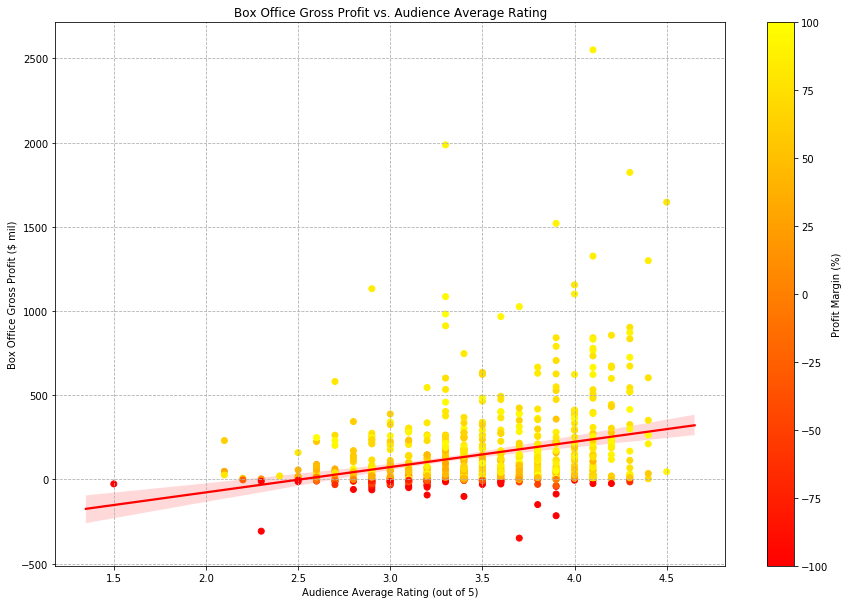

In [14]:
plt.figure(figsize=(15, 10))
sns.regplot('audience_average', 'gross_profit', data=data, scatter_kws={'color': 'none', 'alpha': 0}, line_kws={'color': 'red'})
plt.scatter('audience_average', 'gross_profit', c='profit_margin', cmap='autumn', alpha=1, data=data)
plt.colorbar().set_label('Profit Margin (%)')
plt.title('Box Office Gross Profit vs. Audience Average Rating')
plt.xlabel('Audience Average Rating (out of 5)')
plt.ylabel('Box Office Gross Profit ($ mil)')
plt.grid(ls='--')
plt.show()

## 3. p-value

In [15]:
print('p-value:', reg.pvalue)

p-value: 2.525443957827175e-15


## 4. Conclusion

Since $p-value \approx 2.53 \times 10^{-15} \ll \alpha = 0.05$, we feel comfortable rejecting the null hypothesis, $H_{0}$, in support of the alternative hypothesis, $H_{1}$, such that the slope is significantly different from zero.

We concludue that there is evidence that the slope is significantly different from zero. The movie rating of the audience is significantly (linearly) related to the success of the movie.

# Movie Success Predicition with Linear Regression Model

In [16]:
X = np.stack([data['audience_average']], axis=1)
y = data['gross_profit']
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
print('Slope:', model.coef_[0])
print('Intercept:', model.intercept_)

Slope: 150.260296103294
Intercept: -377.67338561149654


In [17]:
# Split the data into training/validating sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

# Create a linear model
model = LinearRegression(fit_intercept=True)

# Train the model using the training sets
model.fit(X_train, y_train)
print('Training Sets Variance R^2 Score:', model.score(X_train, y_train))
print('Validating Sets Variance R^2 Score', model.score(X_valid, y_valid))

# Make predictions using the validating set
gross_profit_y_pred = model.predict(X_valid)
print('Coefficient:', model.coef_)
print('Mean Squared Error: %.2f' % mean_squared_error(y_valid, gross_profit_y_pred))
# print('Variance R^2 Score: %.2f' % r2_score(y_valid, gross_profit_y_pred))

Training Sets Variance R^2 Score: 0.0712670223797589
Validating Sets Variance R^2 Score 0.11231750838724697
Coefficient: [150.27143568]
Mean Squared Error: 35579.56


As shown above, the scores are very bad: low variance ($R^{2}$) scores and high $MSE$ value. We have no confidence that the score is related to how well the model will predict for **new never-before-seen** values. This may be possibly happening when the data is actually more complex than a simple straight line. For example, in the case when the data seems to be have a linear relationship but is in fact non-linear. At the bottom, we try the polynomial regression technique in hopes of getting a better prediction result.

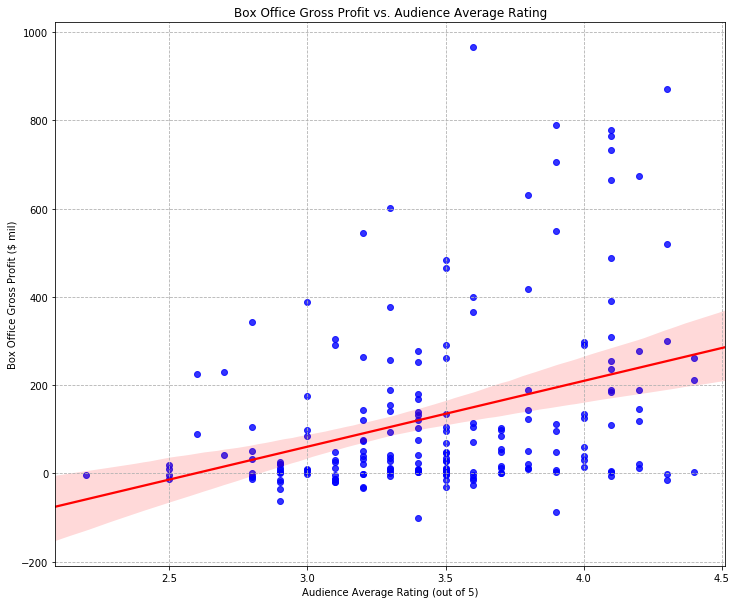

In [18]:
plt.figure(figsize=(12, 10))
sns.regplot(X_valid, y_valid, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Box Office Gross Profit vs. Audience Average Rating')
plt.xlabel('Audience Average Rating (out of 5)')
plt.ylabel('Box Office Gross Profit ($ mil)')
plt.grid(ls='--')
plt.show()

## Toy Story Series

Toy Story

- [Audience Average Rating](https://www.rottentomatoes.com/m/toy_story): 3.75

- [Box Office](https://www.boxofficemojo.com/movies/?id=toystory.htm): $373.6 mil

Toy Story 2

- [Audience Average Rating](https://www.rottentomatoes.com/m/toy_story_2): 4.17

- [Box Office](https://www.boxofficemojo.com/movies/?id=toystory2.htm): $497.4 mil

Toy Story 3

- [Audience Average Rating](https://www.rottentomatoes.com/m/toy_story_3): 4.37

- [Box Office](https://www.boxofficemojo.com/movies/?id=toystory3.htm): $1.067 bil

Toy Story 4

- [Audience Average Rating](https://www.rottentomatoes.com/m/toy_story_4): 4.61

- [Box Office](https://www.boxofficemojo.com/movies/?id=pixar2017.htm): $924.4 mil (as of July 31, 2019)

In [19]:
X_fit = [[3.75], [4.17], [4.37], [4.61]]
y_fit = model.predict(X_fit)
print(y_fit)

[190.24266848 253.35667147 283.4109586  319.47610316]


## Predicted Box Office for Toy Story Series

Toy Story: $193.5 mil

Toy Story 2: $263.3 mil

Toy Story 3: $296.5 mil

Toy Story 4: $336.4 mil

## Polynomial Regression

As mentioned, the scores based on the linear regression model were very bad: low variance $R^{2}$ scores and high $MSE$ value. With the scores, we have no confidence how well the model will predict new never-before-seen values as the example shown above. This may be possibly happening when the data is actually more complex than a simple straight line. As an alternative method, we try the polynomial regression technique in hopes of getting a better prediction result.

In [20]:
def score_polyfit(n):
    """Tests the model using a specified polynomial degree.
    
    Args:
        n: A degree of polynomial.
    Source:
        https://ggbaker.selfip.net/data-science/content/ml.html#trainvalid
    """
    model = make_pipeline(
        PolynomialFeatures(degree=n, include_bias=True),
        LinearRegression(fit_intercept=False)
    )
    model.fit(X_train, y_train)
    print('n=%i: score=%.5g' % (n, model.score(X_valid, y_valid)))
    return model

In [21]:
# https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/ch04.html#polynomial_regression

### Scores with Various Degrees

In [22]:
for i in range(1, 10):
    score_polyfit(i)

n=1: score=0.11232
n=2: score=0.11775
n=3: score=0.086452
n=4: score=0.048427
n=5: score=0.036408
n=6: score=0.036339
n=7: score=0.035789
n=8: score=0.038264
n=9: score=0.058171


### Degree 2 Polynomial (Quadratic)

In [23]:
model = score_polyfit(2)

n=2: score=0.11775


### Visualization

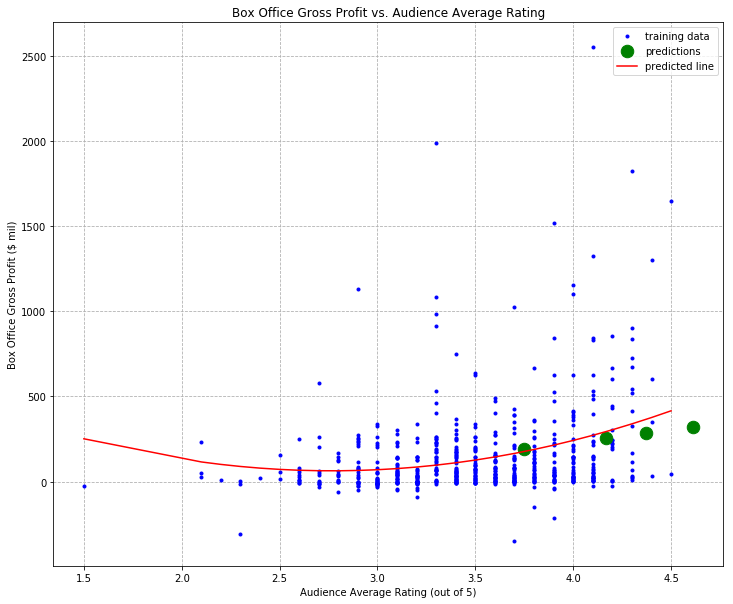

In [24]:
plt.figure(figsize=(12,10))
plt.plot(X_train, y_train, 'b.')
plt.plot(X_fit, y_fit, 'g.', markersize=25)
X = np.sort(X, axis=0)
plt.plot(X, model.predict(X), 'r-')
plt.title('Box Office Gross Profit vs. Audience Average Rating')
plt.xlabel('Audience Average Rating (out of 5)')
plt.ylabel('Box Office Gross Profit ($ mil)')
plt.grid(ls='--')
plt.legend(['training data', 'predictions', 'predicted line'])
plt.show()

Polynomial regression with degree 2 also fails to get a good result. At this moment, it looks like more enhanced tests and analyses are necessary for a better result of the prediction.